
# Introduction

In this lab we will look at two examples where the functional API for Keras is required:

 1. Answering simple questions based on a story.  The network you develop will have multiple inputs; one a set of sentences describing a scenario and the second a question to answer.  This is based on an example from the following sources:
    * this Keras tutorial: https://keras.io/examples/babi_rnn/
    * which is in turn based on this article: http://arxiv.org/abs/1502.05698
 2. Forecasting the temperature and whether or not it will rain the next day based on recent observations of the weather.  In this example, you'll be able to practice specifying multiple outputs for a network.

 # Package imports

In [1]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.preprocessing.sequence import pad_sequences

from __future__ import print_function
from functools import reduce
import re
import tarfile

TensorFlow 1.x selected.


Using TensorFlow backend.


# Example 1: Question Answering

### Utility functions to load and preprocess data

All of the following code is from https://keras.io/examples/babi_rnn/  You don't need to change it at all.

In [17]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.

    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format

    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.

    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

# Default QA1 with 1000 samples
challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
#challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went']
x.shape = (1000, 66)
xq.shape = (1000, 4)
y.shape = (1000, 22)
story_maxlen, query_maxlen = 66, 4


Here's a look at a couple of examples from the training set.  Our network is presented with two inputs:

 * a story where some characters move around and interact with objects.
 * a question about where one of the characters is.

The desired output is the answer to the question.

In [26]:
i = 2
print('Training set story is: ' + ' '.join(train[i][0]))
print('Training set question is: ' + ' '.join(train[i][1]))
print('Training set answer is: ' + train[i][2])

Training set story is: Mary moved to the bathroom . John went to the hallway .
Training set question is: Where is Mary ?
Training set answer is: bathroom


In [29]:
i = 3
print('Training set story is: ' + ' '.join(train[i][0]))
print('Training set question is: ' + ' '.join(train[i][1]))
print('Training set answer is: ' + train[i][2])

Training set story is: Mary moved to the bathroom . John went to the hallway . Daniel went back to the hallway . Sandra moved to the garden . John moved to the office . Sandra journeyed to the bathroom . Mary moved to the hallway . Daniel travelled to the office .
Training set question is: Where is Daniel ?
Training set answer is: office


Note that the training set stories are sparsely encoded in the array `x`, the training set questions are sparsely encoded in the array `xq`, and the training set answers are one-hot encoded in the array `y`.  The stories have been padded with leading 0s to the length of the longest story:

In [36]:
print("Sparse encoding of story 2: " + str(x[2, :]))
print("Sparse encoding of question 2: " + str(xq[2, :]))
print("One-hot encoding of answer 2: " + str(y[2]))

Sparse encoding of story 2: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  5 16 19 18  9  1  4 21 19 18 12  1  3 21  8 19 18 12  1
  6 16 19 18 11  1  4 16 19 18 17  1  6 14 19 18  9  1]
Sparse encoding of question 2: [ 7 13  3  2]
One-hot encoding of answer 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


One final note: this is a hard task!  The original Facebook article describing the task achieved only 50% classification accuracy, and we will have similar results (as I developed this, I got between about 46% and 52% on different estimation runs).  Our training set size is only 1000 sets of story/question/answer triples.

## Build and Fit Model

#### 1. Let's build a model to do this with the following structure:

 * Input branch one (the sentences/story)
    * `sentence` is created by `layers.Input` with shape `(story_maxlen,)`, `dtype='int32'`, and and an appropriate `name`.
    * `embedded_sentence` is created by `layers.Embedding` with: first argument `vocab_size`, the number of words in the stories; second argument 25 for embedding dimension 25.  What should the function returned by `layers.Embedding` be called on?  (What is the input to this layer?)
    * `encoded_sentence` is created by `layers.recurrent.LSTM` with 100 units in the LSTM layer.  Specify that the function for the LSTM layer is called on the appropriate input.
 * Input branch two (the question)
    * `question` is created by `layers.Input` with shape `(query_maxlen,)`, `dtype='int32'`, and and an appropriate `name`.
    * `embedded_question` is created in the same way as `embedded_sentence`, but with the appropriate input from the previous layer.
    * `encoded_question` is created in the same way as `encoded_sentence`, but with the appropriate input from the previous layer.
 * Concatenate the activation outputs from the two LSTM layers using `layers.concatenate`.  You will need to provide a list with the `encoded_sentence` and the `encoded_question`.  The default value for axis is -1, so you can leave that out if you want.  This is the only layer where you don't need an extra set of parentheses at the end with the outputs from the previous layer, since they were already provided.
 * Add a dense output layer with `layers.Dense`.  The number of units in the output layer should be `vocab_size` (in theory, any word in the vocabulary could be the correct answer to the question).  Specify an appropriate activation function, and the appropriate input from the previous layer.


In [40]:
# Input branch 1
## Input layer for sentence
sentence = layers.Input(shape=(story_maxlen,), dtype='int32', name='sentence')
## Embedding layer for sentence
embedded_sentence = layers.Embedding(vocab_size, 25)(sentence)
## LSTM for sentence
encoded_sentence = layers.recurrent.LSTM(100)(embedded_sentence)

# Input branch 2
## Input layer for question
question = layers.Input(shape=(query_maxlen,), dtype='int32', name='question')
## Embedding layer for question
embedded_question = layers.Embedding(vocab_size, 25)(question)
## LSTM for question
encoded_question = layers.recurrent.LSTM(100)(embedded_question)

# Concatenate LSTM outputs
merged = layers.concatenate([encoded_sentence, encoded_question], axis = -1)
# Output predictions layer
preds = layers.Dense(vocab_size, activation='softmax')(merged)

# Define model; you'll need a list of inputs
model = models.Model(inputs=[sentence, question], outputs=preds)

# Compile model; nothing for you to do here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to the training data
# specify a dictionary of inputs for the first argument to model.fit
model.fit({'sentence': x, 'question': xq}, y,
          batch_size=32,
          epochs=30,
          validation_split=0.05)

# Evaluate on test set; nothing for you to do here
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Train on 950 samples, validate on 50 samples
Epoch 1/30
950/950 [==============================] - 6s 6ms/step - loss: 2.4210 - acc: 0.1589 - val_loss: 1.8814 - val_acc: 0.0800
Epoch 2/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8181 - acc: 0.1600 - val_loss: 1.8290 - val_acc: 0.0400
Epoch 3/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8070 - acc: 0.1621 - val_loss: 1.7947 - val_acc: 0.0800
Epoch 4/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8092 - acc: 0.1495 - val_loss: 1.8509 - val_acc: 0.1800
Epoch 5/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8051 - acc: 0.1695 - val_loss: 1.8694 - val_acc: 0.0400
Epoch 6/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8120 - acc: 0.1453 - val_loss: 1.8274 - val_acc: 0.0800
Epoch 7/30
950/950 [==============================] - 2s 2ms/step - loss: 1.8019 - acc: 0.1926 - val_loss: 1.7785 - val_acc: 0.2000
Epoch 8/30
950/950 [===========

Here's a summary of the model you defined above:

In [59]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence (InputLayer)           (None, 66)           0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 66, 25)       550         sentence[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 4, 25)        550         question[0][0]                   
____________________________________________________________________________________________

#### 2. In a sentence or two, explain why the lstm layers and the concatenate layer have the output shape they do.

We specified that the LSTM layers would have 100 units when we created them.  The first dimension of None represents an unspecified number of observations in a particular batch.

When we concatenated two layers of 100 units together, we got all 200 units in the concatenated results.

# Example 2: Weather Forecasting

Suppose we want to use the weather over the last 30 days to predict:

 * the daily high temperature tomorrow
 * whether or not it will rain tomorrow

This doesn't really work (our classification accuracy for whether or not it will rain is disappointing), but I couldn't think of another example to demonstrate a network with multiple outputs that wouldn't take forever to run...

### Data Preprocessing

Here's a look at the data set of weather in South Hadley, after filtering to data since the year 1970 and keeping only the variables we will use.

In [0]:
weather = pd.read_csv("http://www.evanlray.com/data/misc/south_hadley_weather/daily_weather.csv")
weather = weather[weather.year >= 1971]
weather['rained'] = weather.events.str.contains('Rain').fillna(value = 0).astype('int')

vars_to_keep = ['temp_avg_F', 'dew_pt_avg_F', 'humidity_avg_pct',
                'sea_level_press_avg_in', 'wind_avg_mph', 'rained']
vars_to_keep = ['temp_high_F', 'temp_avg_F', 'temp_low_F', 'dew_pt_high_F',
       'dew_pt_avg_F', 'dew_pt_low_F', 'humidity_high_pct', 'humidity_avg_pct',
       'humidity_low_pct', 'sea_level_press_high_in', 'sea_level_press_avg_in',
       'sea_level_press_low_in', 'wind_high_mph', 'wind_avg_mph',
       'rained']
#       'precipitation_in']
weather = weather.loc[:, vars_to_keep]

In [42]:
weather.head()

,temp_high_F,temp_avg_F,temp_low_F,dew_pt_high_F,dew_pt_avg_F,dew_pt_low_F,humidity_high_pct,humidity_avg_pct,humidity_low_pct,sea_level_press_high_in,sea_level_press_avg_in,sea_level_press_low_in,wind_high_mph,wind_avg_mph,rained
10867,28.0,24.0,19.0,20.0,16.0,9.0,81.0,71.0,58.0,29.95,29.76,29.63,17.0,8.0,0
10868,33.0,22.0,10.0,25.0,15.0,4.0,84.0,66.0,46.0,30.08,29.98,29.81,9.0,2.0,0
10869,38.0,26.0,14.0,22.0,18.0,7.0,88.0,65.0,51.0,30.31,30.19,30.07,21.0,5.0,0
10870,34.0,25.0,16.0,31.0,21.0,10.0,89.0,79.0,61.0,30.31,30.19,29.98,5.0,1.0,1
10871,40.0,36.0,30.0,33.0,27.0,15.0,92.0,73.0,46.0,29.96,29.83,29.75,17.0,4.0,1


Is there any missing data?

In [43]:
weather.isnull().sum()

temp_high_F                5
temp_avg_F                 7
temp_low_F                 5
dew_pt_high_F              5
dew_pt_avg_F               5
dew_pt_low_F               5
humidity_high_pct          5
humidity_avg_pct           5
humidity_low_pct           5
sea_level_press_high_in    5
sea_level_press_avg_in     5
sea_level_press_low_in     5
wind_high_mph              5
wind_avg_mph               5
rained                     0
dtype: int64

Yes, there is missing data.  The following function fills in missing values wtih the previous observed value for that variable in the data set.

In [0]:
weather = weather.fillna(method='pad')

In [45]:
weather.isnull().sum()

temp_high_F                0
temp_avg_F                 0
temp_low_F                 0
dew_pt_high_F              0
dew_pt_avg_F               0
dew_pt_low_F               0
humidity_high_pct          0
humidity_avg_pct           0
humidity_low_pct           0
sea_level_press_high_in    0
sea_level_press_avg_in     0
sea_level_press_low_in     0
wind_high_mph              0
wind_avg_mph               0
rained                     0
dtype: int64

All better :)  Let's convert from a pandas data frame to a numpy array.

In [0]:
weather = weather.to_numpy()

Here is a plot of the daily average temperature (in degrees F) since 1940.  To be able to see the patterns more clearly, I have split the data up over two subplots.

In [47]:
len(weather)/2

8558.5

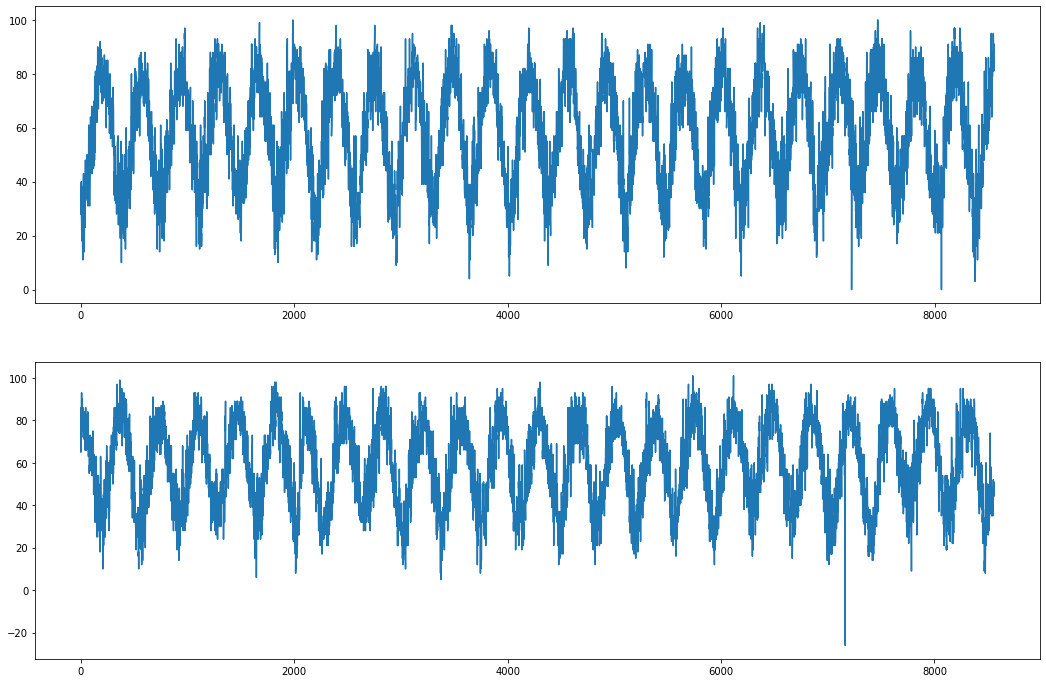

In [48]:
fig, ax = plt.subplots(2, 1, figsize = (18, 12))
ax[0].plot(weather[:8558, 0])
ax[1].plot(weather[8558:, 0])

A plot of rain vs. no rain wasn't informative, but here's the proportion of days in the data set when it rained in South Hadley:

In [52]:
np.mean(weather[:, 14])

0.3359817725068645

#### Approach to train/validation/test split

This has not changed since the last lab on this topic.  As a reminder:

 * Rather than getting a random split, with time series data it's common to divide the data into contiguous blocks, with the train set being the beginning of the time series, the validation set next, and the test set last.  In this way, you never look at "future" data as part of the training or validation set.
 * We'll use the first 10240 observations (evenly divisible by a batch size of 128, about 60% of the data set) for the training set, the next 3456 (divisible by 128, about 20% of the data set) for the validation set, and the final 3421 observations for the test set.
 * Rather than explicitly splitting the data, we'll keep track of these indices and create a generator for each data set that knows about the data set it should use.

#### Standardize input features

We need to standardize the explanatory variables, as usual.  For ease of interpretation, we do not standardize the response variables

In [0]:
# when standardizing, calculate the mean and standard deviation based on
# only the training set, but standardize the full data set.
train_mean = weather[:10240, 1:-1].mean(axis=0)
weather[:, 1:-1] = weather[:, 1:-1] - train_mean
train_std = weather[:10240, 1:-1].std(axis=0)
weather[:, 1:-1] = weather[:, 1:-1] / train_std

## Generators

We define generators for batches of observations.  This code is almost the same as in our previous lab on this data set, with one minor adjustment: a new argument called `output`, which may be either 'both', 'temp', or 'precip'.  If it is 'both', the generator will return a dictionary with values of temperature and precipitation.  Otherwise, it will return only a numpy array for the specified variable.  We create a set of training, validation, and test set generators to work with both target variables at once.

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1, output = 'both'):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        temp_targets = np.zeros((len(rows),))
        precip_targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            temp_targets[j] = data[rows[j] + delay][0]
            precip_targets[j] = data[rows[j] + delay][-1]
        
        if output == 'both':
          yield samples, {'temp': temp_targets, 'precip': precip_targets}
        elif output == 'temp':
          yield samples, temp_targets
        elif output == 'precip':
          yield samples, precip_targets
        else:
          print('invalid argument "output": must be "both", "temp", or "precip"')
          raise ValueError()

In [0]:
train_both_gen = generator(weather,
                      lookback=30,
                      delay=1,
                      min_index=0,
                      max_index=10240,
                      shuffle=True,
                      step=1,
                      batch_size=128,
                      output='both')
val_both_gen = generator(weather,
                    lookback=30,
                    delay=1,
                    min_index=10241,
                    max_index=13696,
                    shuffle=False,
                    step=1,
                    batch_size=128,
                    output='both')
test_both_gen = generator(weather,
                     lookback=30,
                     delay=1,
                     min_index=13697,
                     max_index=None,
                     shuffle=False,
                     step=1,
                     batch_size=128,
                     output='both')

lookback = 30
batch_size = 128
train_steps = (16896 - lookback) // batch_size
val_steps = (22528 - 16897 - lookback) // batch_size
tes_steps = (len(weather) - 22528 - lookback) // batch_size

### 3. GRU Model via Functional API

Recall that last time we worked with this example, a GRU had best performance.  Let's try a GRU model again.

 * Your `Input` layer should have `input_shape = (None, weather.shape[-1])`, `dtype = 'float', and an appropriate `name`.
 * Add a `layers.GRU` with 32 hidden units and the output from your previous layer as input
 * Add two separate Dense output layers, one for temperature and the other for precipitation.  Give them the names `'temp'` and `'precip'` respectively.  (This is necessary to match the naming convention I set up in the generator above.)
 * Create a model with a list of outputs
 * Compile the model with `'mae'` for the loss for `'temp'` and `'binary_crossentropy'` for the loss or `'precip'`.  Add `['accuracy']` as an additional metric.
 * I have provided the code for fitting using `fit_generator()`.

In [63]:
# Define input layer
weather_input = layers.Input(shape=(None, weather.shape[-1]), dtype='float', name='weather')

# GRU layer
x = layers.GRU(32)(weather_input)

# output layer for temperature
temp_prediction = layers.Dense(1, activation='linear', name = 'temp')(x)

# output layer for precipitation
precip_prediction = layers.Dense(1, activation='sigmoid', name = 'precip')(x)

# model.  You will need a list for the outputs
both_model = models.Model(inputs=weather_input, outputs=[temp_prediction, precip_prediction])

# compile the model.  specify a dictionary for the loss.
both_model.compile(
    optimizer='rmsprop',
    loss={'temp': 'mae', 'precip': 'binary_crossentropy'},
    metrics = ['accuracy'])

# fit the model.
both_model.fit_generator(train_both_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=val_both_gen,
                    validation_steps=val_steps)

Epoch 1/20
131/131 [==============================] - 7s 51ms/step - loss: 55.4354 - temp_loss: 54.7937 - precip_loss: 0.6417 - temp_acc: 5.9637e-05 - precip_acc: 0.6785 - val_loss: 50.8880 - val_temp_loss: 50.2595 - val_precip_loss: 0.6286 - val_temp_acc: 0.0018 - val_precip_acc: 0.6875
Epoch 2/20
131/131 [==============================] - 4s 28ms/step - loss: 47.2450 - temp_loss: 46.6106 - precip_loss: 0.6344 - temp_acc: 0.0011 - precip_acc: 0.6749 - val_loss: 45.8076 - val_temp_loss: 45.1816 - val_precip_loss: 0.6260 - val_temp_acc: 0.0011 - val_precip_acc: 0.6811
Epoch 3/20
131/131 [==============================] - 4s 27ms/step - loss: 43.0123 - temp_loss: 42.3834 - precip_loss: 0.6289 - temp_acc: 0.0020 - precip_acc: 0.6778 - val_loss: 40.8894 - val_temp_loss: 40.2632 - val_precip_loss: 0.6262 - val_temp_acc: 0.0060 - val_precip_acc: 0.6810
Epoch 4/20
131/131 [==============================] - 4s 27ms/step - loss: 39.0119 - temp_loss: 38.3825 - precip_loss: 0.6294 - temp_acc: 0.0

Note in your estimation output above that the loss for temperature is an order of magnitude larger than the loss for precipitation.  This could be addressed in the estimation by specifying 'loss_weights', but you don't need to do that.